<a href="https://colab.research.google.com/github/mdsiam135/thesis_2025/blob/main/HistGradientBoostingClassifier(3_labels).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [29]:
# ============================================================================
# STEP-BY-STEP HISTGRADIENTBOOSTINGCLASSIFIER FOR AGRICULTURAL PRODUCTION
# ============================================================================

# Step 1: Import Required Libraries
# ============================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                           f1_score, confusion_matrix, classification_report, log_loss)
import warnings
warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('default')
sns.set_palette("husl")
np.random.seed(42)

print("Step 1: Libraries imported successfully!")

Step 1: Libraries imported successfully!


In [30]:
# Step 2: Load and Explore the Datasets
# ============================================================================
print("\nStep 2: Loading datasets...")

# Load datasets
try:
    train_df = pd.read_csv('/content/drive/MyDrive/UpdatedDataset/train.csv')
    val_df = pd.read_csv('/content/drive/MyDrive/UpdatedDataset/validation.csv')
    test_df = pd.read_csv('/content/drive/MyDrive/UpdatedDataset/test.csv')

    print(f"✓ Training data shape: {train_df.shape}")
    print(f"✓ Validation data shape: {val_df.shape}")
    print(f"✓ Test data shape: {test_df.shape}")

    # Display basic info
    print(f"\nDataset Overview:")
    print(f"Total features: {len(train_df.columns) - 1}")  # -1 for target column
    print(f"Target column: Production (M.Ton)")

    # Check for missing values
    print(f"\nMissing values in training data: {train_df.isnull().sum().sum()}")
    print(f"Missing values in validation data: {val_df.isnull().sum().sum()}")
    print(f"Missing values in test data: {test_df.isnull().sum().sum()}")

except FileNotFoundError as e:
    print(f"❌ Error: CSV files not found. Please ensure files exist:")
    print("- train.csv")
    print("- validation.csv")
    print("- test.csv")


Step 2: Loading datasets...
✓ Training data shape: (3942, 84)
✓ Validation data shape: (845, 84)
✓ Test data shape: (845, 84)

Dataset Overview:
Total features: 83
Target column: Production (M.Ton)

Missing values in training data: 0
Missing values in validation data: 0
Missing values in test data: 0


In [31]:


# Step 3: Create Target Labels Based on Quantiles
# ============================================================================
print("\nStep 3: Creating target labels...")

production_col = 'Production (M.Ton)'

# Calculate quantiles from training data only
q33 = train_df[production_col].quantile(0.33)
q67 = train_df[production_col].quantile(0.67)

print(f"Quantile boundaries:")
print(f"- Low: <= {q33:.2f} M.Ton")
print(f"- Medium: {q33:.2f} - {q67:.2f} M.Ton")
print(f"- High: > {q67:.2f} M.Ton")

def categorize_production(production_value):
    if production_value <= q33:
        return 'low'
    elif production_value <= q67:
        return 'medium'
    else:
        return 'high'

# Create labels for all datasets
train_labels = train_df[production_col].apply(categorize_production)
val_labels = val_df[production_col].apply(categorize_production)
test_labels = test_df[production_col].apply(categorize_production)

# Display label distribution
print(f"\nLabel distribution:")
print("Training set:")
print(train_labels.value_counts().sort_index())
print("Validation set:")
print(val_labels.value_counts().sort_index())
print("Test set:")
print(test_labels.value_counts().sort_index())


Step 3: Creating target labels...
Quantile boundaries:
- Low: <= 1071.56 M.Ton
- Medium: 1071.56 - 4035.91 M.Ton
- High: > 4035.91 M.Ton

Label distribution:
Training set:
Production (M.Ton)
high      1301
low       1301
medium    1340
Name: count, dtype: int64
Validation set:
Production (M.Ton)
high      270
low       278
medium    297
Name: count, dtype: int64
Test set:
Production (M.Ton)
high      291
low       274
medium    280
Name: count, dtype: int64


In [32]:
# Step 4: Prepare Features (Remove Target Column and Handle Missing Values)
# ============================================================================
print("\nStep 4: Preparing features...")

# Remove target column to get features
target_col = 'Production (M.Ton)'
X_train = train_df.drop(columns=[target_col])
X_val = val_df.drop(columns=[target_col])
X_test = test_df.drop(columns=[target_col])

print(f"Features extracted: {X_train.shape[1]} columns")

# Handle missing values - fill with training set mean
print("Handling missing values...")
train_means = X_train.mean()

X_train_filled = X_train.fillna(train_means)
X_val_filled = X_val.fillna(train_means)  # Use train means
X_test_filled = X_test.fillna(train_means)  # Use train means

print(f"✓ Missing values handled")
print(f"✓ Feature columns: {list(X_train_filled.columns[:5])}... (showing first 5)")

feature_names = list(X_train_filled.columns)


Step 4: Preparing features...
Features extracted: 83 columns
Handling missing values...
✓ Missing values handled
✓ Feature columns: ['Area (Acres)', 'Temperature at 2 Meters Range (C)', 'Year', 'soil_temperature_0_to_7cm(C)', 'Root Zone Soil Wetness (surface to 100 cm below)']... (showing first 5)


In [33]:
# Step 5: Scale Features and Encode Labels
# ============================================================================
print("\nStep 5: Scaling features and encoding labels...")

# Initialize scalers and encoders
scaler = StandardScaler()
label_encoder = LabelEncoder()

# Scale features
print("Scaling features...")
X_train_scaled = scaler.fit_transform(X_train_filled)
X_val_scaled = scaler.transform(X_val_filled)
X_test_scaled = scaler.transform(X_test_filled)

# Encode labels (low=0, medium=1, high=2)
print("Encoding labels...")
y_train_encoded = label_encoder.fit_transform(train_labels)
y_val_encoded = label_encoder.transform(val_labels)
y_test_encoded = label_encoder.transform(test_labels)

print(f"✓ Features scaled to mean=0, std=1")
print(f"✓ Labels encoded: {dict(zip(label_encoder.classes_, range(len(label_encoder.classes_))))}")


Step 5: Scaling features and encoding labels...
Scaling features...
Encoding labels...
✓ Features scaled to mean=0, std=1
✓ Labels encoded: {'high': 0, 'low': 1, 'medium': 2}


In [34]:
# Step 6: Initialize and Configure the Model
# ============================================================================
print("\nStep 6: Initializing HistGradientBoostingClassifier...")

model = HistGradientBoostingClassifier(
    max_iter=100,              # Maximum number of boosting iterations
    learning_rate=0.5,         # Learning rate (step size)
    max_depth=6,               # Maximum depth of trees
    min_samples_leaf=20,       # Minimum samples in leaf nodes
    l2_regularization=0.1,     # L2 regularization strength
    early_stopping=True,       # Enable early stopping
    validation_fraction=0.1,   # Fraction for early stopping validation
    n_iter_no_change=5,        # Iterations without improvement to stop
    random_state=42           # For reproducibility
)

print("✓ Model initialized with parameters:")
print(f"  - Max iterations: 100")
print(f"  - Learning rate: 0.5")
print(f"  - Max depth: 6")
print(f"  - Early stopping: Enabled")


Step 6: Initializing HistGradientBoostingClassifier...
✓ Model initialized with parameters:
  - Max iterations: 100
  - Learning rate: 0.5
  - Max depth: 6
  - Early stopping: Enabled


In [35]:
# Step 7: Train Model with Epoch Tracking
# ============================================================================
print(f"\nStep 7: Training model with epoch tracking...")

# Create epoch ranges for tracking
max_epochs = 100
epoch_range = list(range(10, max_epochs + 1, 10))
train_accuracies = []
val_accuracies = []
train_losses = []
val_losses = []

print("Training progress:")
print("Epoch | Train Acc | Val Acc | Train Loss | Val Loss")
print("-" * 50)

# Train models with different iteration counts to simulate epochs
for n_iter in epoch_range:
    # Create temporary model for this "epoch"
    temp_model = HistGradientBoostingClassifier(
        max_iter=n_iter,
        learning_rate=0.1,
        max_depth=6,
        min_samples_leaf=20,
        l2_regularization=0.1,
        random_state=42
    )

    # Train model
    temp_model.fit(X_train_scaled, y_train_encoded)

    # Get predictions and probabilities
    train_pred = temp_model.predict(X_train_scaled)
    val_pred = temp_model.predict(X_val_scaled)
    train_proba = temp_model.predict_proba(X_train_scaled)
    val_proba = temp_model.predict_proba(X_val_scaled)

    # Calculate accuracies
    train_acc = accuracy_score(y_train_encoded, train_pred)
    val_acc = accuracy_score(y_val_encoded, val_pred)

    # Calculate losses (log loss)
    train_loss = log_loss(y_train_encoded, train_proba)
    val_loss = log_loss(y_val_encoded, val_proba)

    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f"{n_iter:5d} | {train_acc:9.4f} | {val_acc:7.4f} | {train_loss:10.4f} | {val_loss:8.4f}")

# Train final model with full epochs
final_model = HistGradientBoostingClassifier(
    max_iter=max_epochs,
    learning_rate=0.1,
    max_depth=6,
    min_samples_leaf=20,
    l2_regularization=0.1,
    early_stopping=True,
    validation_fraction=0.1,
    n_iter_no_change=5,
    random_state=42
)

print(f"\nTraining final model...")
final_model.fit(X_train_scaled, y_train_encoded)
print(f"✓ Final model trained successfully!")


Step 7: Training model with epoch tracking...
Training progress:
Epoch | Train Acc | Val Acc | Train Loss | Val Loss
--------------------------------------------------
   10 |    0.8929 |  0.8615 |     0.3628 |   0.4059
   20 |    0.9130 |  0.8710 |     0.2490 |   0.3152
   30 |    0.9302 |  0.8817 |     0.2010 |   0.2830
   40 |    0.9457 |  0.8864 |     0.1724 |   0.2644
   50 |    0.9561 |  0.8899 |     0.1506 |   0.2540
   60 |    0.9658 |  0.8959 |     0.1340 |   0.2464
   70 |    0.9729 |  0.9041 |     0.1184 |   0.2416
   80 |    0.9795 |  0.9030 |     0.1067 |   0.2402
   90 |    0.9825 |  0.9053 |     0.0956 |   0.2377
  100 |    0.9868 |  0.9041 |     0.0862 |   0.2378

Training final model...
✓ Final model trained successfully!


In [36]:
# Step 8: Calculate All Classification Metrics
# ============================================================================
print(f"\nStep 8: Calculating metrics...")

# Training Set Metrics
print(f"\nStep 8a: Calculating metrics for TRAINING SET...")
y_train_pred = final_model.predict(X_train_scaled)

train_accuracy = accuracy_score(y_train_encoded, y_train_pred)
train_precision = precision_score(y_train_encoded, y_train_pred, average='weighted')
train_recall = recall_score(y_train_encoded, y_train_pred, average='weighted')
train_f1_weighted = f1_score(y_train_encoded, y_train_pred, average='weighted')
train_f1_macro = f1_score(y_train_encoded, y_train_pred, average='macro')
train_cm = confusion_matrix(y_train_encoded, y_train_pred)

print(f"\nTRAINING SET Results:")
print("-" * 40)
print(f"Accuracy:           {train_accuracy:.4f}")
print(f"Precision (Weighted): {train_precision:.4f}")
print(f"Recall (Weighted):    {train_recall:.4f}")
print(f"F1-Score (Weighted):  {train_f1_weighted:.4f}")
print(f"Macro F1-Score:       {train_f1_macro:.4f}")

class_names = label_encoder.classes_
train_report = classification_report(y_train_encoded, y_train_pred, target_names=class_names)
print(f"\nDetailed Classification Report:")
print(train_report)

# Validation Set Metrics
print(f"\nStep 8b: Calculating metrics for VALIDATION SET...")
y_val_pred = final_model.predict(X_val_scaled)

val_accuracy = accuracy_score(y_val_encoded, y_val_pred)
val_precision = precision_score(y_val_encoded, y_val_pred, average='weighted')
val_recall = recall_score(y_val_encoded, y_val_pred, average='weighted')
val_f1_weighted = f1_score(y_val_encoded, y_val_pred, average='weighted')
val_f1_macro = f1_score(y_val_encoded, y_val_pred, average='macro')
val_cm = confusion_matrix(y_val_encoded, y_val_pred)

print(f"\nVALIDATION SET Results:")
print("-" * 40)
print(f"Accuracy:           {val_accuracy:.4f}")
print(f"Precision (Weighted): {val_precision:.4f}")
print(f"Recall (Weighted):    {val_recall:.4f}")
print(f"F1-Score (Weighted):  {val_f1_weighted:.4f}")
print(f"Macro F1-Score:       {val_f1_macro:.4f}")

val_report = classification_report(y_val_encoded, y_val_pred, target_names=class_names)
print(f"\nDetailed Classification Report:")
print(val_report)

# Test Set Metrics
print(f"\nStep 8c: Calculating metrics for TEST SET...")
y_test_pred = final_model.predict(X_test_scaled)

test_accuracy = accuracy_score(y_test_encoded, y_test_pred)
test_precision = precision_score(y_test_encoded, y_test_pred, average='weighted')
test_recall = recall_score(y_test_encoded, y_test_pred, average='weighted')
test_f1_weighted = f1_score(y_test_encoded, y_test_pred, average='weighted')
test_f1_macro = f1_score(y_test_encoded, y_test_pred, average='macro')
test_cm = confusion_matrix(y_test_encoded, y_test_pred)

print(f"\nTEST SET Results:")
print("-" * 40)
print(f"Accuracy:           {test_accuracy:.4f}")
print(f"Precision (Weighted): {test_precision:.4f}")
print(f"Recall (Weighted):    {test_recall:.4f}")
print(f"F1-Score (Weighted):  {test_f1_weighted:.4f}")
print(f"Macro F1-Score:       {test_f1_macro:.4f}")

test_report = classification_report(y_test_encoded, y_test_pred, target_names=class_names)
print(f"\nDetailed Classification Report:")
print(test_report)


Step 8: Calculating metrics...

Step 8a: Calculating metrics for TRAINING SET...

TRAINING SET Results:
----------------------------------------
Accuracy:           0.9769
Precision (Weighted): 0.9769
Recall (Weighted):    0.9769
F1-Score (Weighted):  0.9769
Macro F1-Score:       0.9770

Detailed Classification Report:
              precision    recall  f1-score   support

        high       0.98      0.99      0.98      1301
         low       0.98      0.99      0.98      1301
      medium       0.98      0.96      0.97      1340

    accuracy                           0.98      3942
   macro avg       0.98      0.98      0.98      3942
weighted avg       0.98      0.98      0.98      3942


Step 8b: Calculating metrics for VALIDATION SET...

VALIDATION SET Results:
----------------------------------------
Accuracy:           0.8899
Precision (Weighted): 0.8899
Recall (Weighted):    0.8899
F1-Score (Weighted):  0.8899
Macro F1-Score:       0.8910

Detailed Classification Report:
   


Step 9: Plotting confusion matrices...


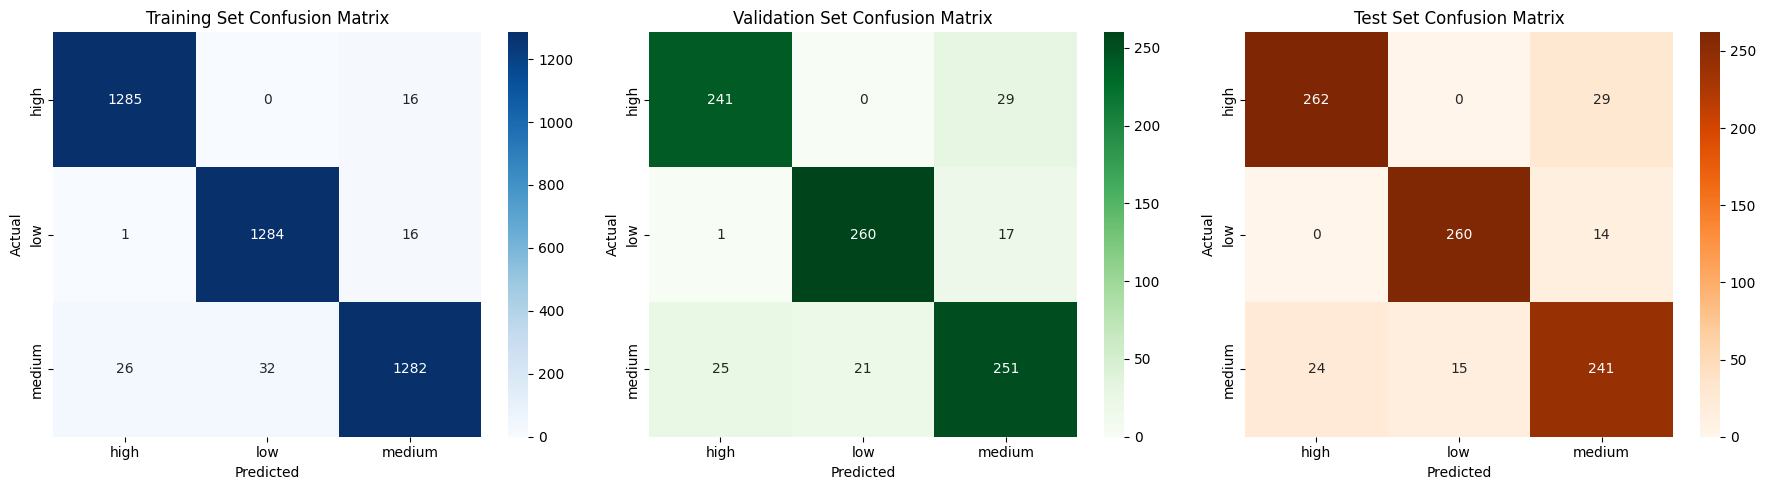

✓ Confusion matrices plotted successfully!


In [37]:
# Step 9: Plot Confusion Matrices
# ============================================================================
print(f"\nStep 9: Plotting confusion matrices...")

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Training confusion matrix
sns.heatmap(train_cm, annot=True, fmt='d',
            cmap='Blues', xticklabels=class_names, yticklabels=class_names,
            ax=axes[0])
axes[0].set_title('Training Set Confusion Matrix')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

# Validation confusion matrix
sns.heatmap(val_cm, annot=True, fmt='d',
            cmap='Greens', xticklabels=class_names, yticklabels=class_names,
            ax=axes[1])
axes[1].set_title('Validation Set Confusion Matrix')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

# Test confusion matrix
sns.heatmap(test_cm, annot=True, fmt='d',
            cmap='Oranges', xticklabels=class_names, yticklabels=class_names,
            ax=axes[2])
axes[2].set_title('Test Set Confusion Matrix')
axes[2].set_xlabel('Predicted')
axes[2].set_ylabel('Actual')

plt.tight_layout()
plt.show()
print("✓ Confusion matrices plotted successfully!")


Step 10: Plotting training curves...


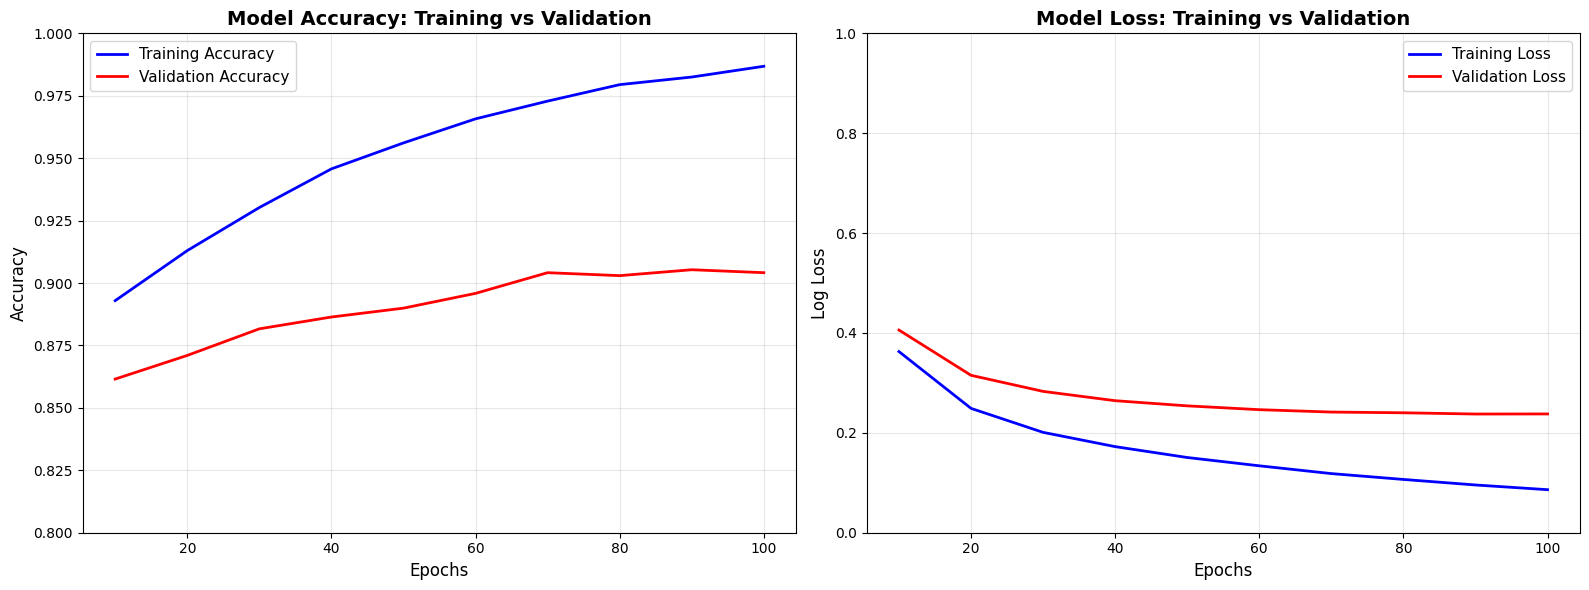

✓ Training curves plotted successfully!


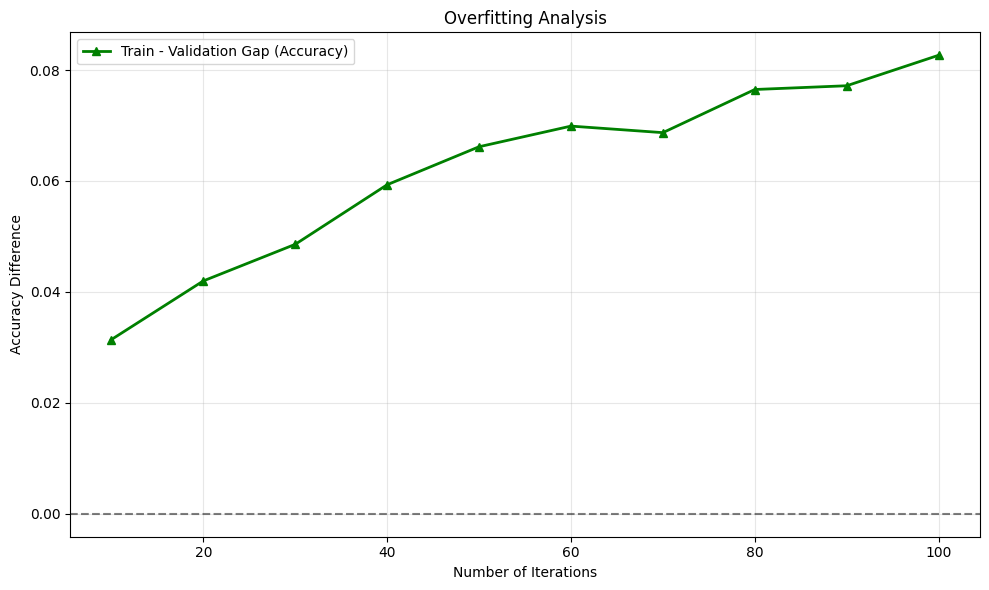

In [38]:
# Step 10: Plot Training vs Validation Curves (ENHANCED VERSION)
# ============================================================================
print(f"\nStep 10: Plotting training curves...")

# Create figure with 2 subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Left plot: Model Accuracy - Training vs Validation
ax1.plot(epoch_range, train_accuracies, 'b-', label='Training Accuracy', linewidth=2)
ax1.plot(epoch_range, val_accuracies, 'r-', label='Validation Accuracy', linewidth=2)
ax1.set_title('Model Accuracy: Training vs Validation', fontsize=14, fontweight='bold')
ax1.set_xlabel('Epochs', fontsize=12)
ax1.set_ylabel('Accuracy', fontsize=12)
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)
ax1.set_ylim([0.8, 1.0])  # Adjust based on your data range

# Right plot: Model Loss - Training vs Validation
ax2.plot(epoch_range, train_losses, 'b-', label='Training Loss', linewidth=2)
ax2.plot(epoch_range, val_losses, 'r-', label='Validation Loss', linewidth=2)
ax2.set_title('Model Loss: Training vs Validation', fontsize=14, fontweight='bold')
ax2.set_xlabel('Epochs', fontsize=12)
ax2.set_ylabel('Log Loss', fontsize=12)
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)
ax2.set_ylim([0.0, 1.0])  # Adjust based on your data range

plt.tight_layout()
plt.show()
print("✓ Training curves plotted successfully!")

# Additional overfitting analysis plot
fig, ax3 = plt.subplots(1, 1, figsize=(10, 6))

# Difference between train and validation
acc_diff = [t - v for t, v in zip(train_accuracies, val_accuracies)]
ax3.plot(epoch_range, acc_diff, 'g-', label='Train - Validation Gap (Accuracy)', linewidth=2, marker='^')
ax3.axhline(y=0, color='black', linestyle='--', alpha=0.5)
ax3.set_title('Overfitting Analysis')
ax3.set_xlabel('Number of Iterations')
ax3.set_ylabel('Accuracy Difference')
ax3.legend()
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [39]:
# Step 11: Create Results Summary Table
# ============================================================================
print(f"\nStep 11: Creating results summary table...")

# Create summary DataFrame
summary_data = {
    'Metric': ['Accuracy', 'Precision (Weighted)', 'Recall (Weighted)',
              'F1-Score (Weighted)', 'Macro F1-Score'],
    'Training': [train_accuracy, train_precision, train_recall, train_f1_weighted, train_f1_macro],
    'Validation': [val_accuracy, val_precision, val_recall, val_f1_weighted, val_f1_macro],
    'Test': [test_accuracy, test_precision, test_recall, test_f1_weighted, test_f1_macro]
}

summary_df = pd.DataFrame(summary_data)

print("\n" + "="*70)
print("FINAL RESULTS SUMMARY")
print("="*70)
print(summary_df.round(4).to_string(index=False))

# Highlight best performances
print(f"\n🏆 BEST PERFORMANCES:")
print(f"Best Test Accuracy: {test_accuracy:.4f}")
print(f"Best Test Macro F1: {test_f1_macro:.4f}")


# Final Summary
# ============================================================================
print(f"\n🎉 ALL STEPS COMPLETED SUCCESSFULLY!")
print(f"📊 Model trained and evaluated on {len(feature_names)} features")
print(f"🎯 Final Test Macro F1-Score: {test_f1_macro:.4f}")
print(f"✅ Analysis completed successfully!")
print(f"📈 All results calculated and visualized")


Step 11: Creating results summary table...

FINAL RESULTS SUMMARY
              Metric  Training  Validation   Test
            Accuracy    0.9769      0.8899 0.9030
Precision (Weighted)    0.9769      0.8899 0.9032
   Recall (Weighted)    0.9769      0.8899 0.9030
 F1-Score (Weighted)    0.9769      0.8899 0.9031
      Macro F1-Score    0.9770      0.8910 0.9033

🏆 BEST PERFORMANCES:
Best Test Accuracy: 0.9030
Best Test Macro F1: 0.9033

🎉 ALL STEPS COMPLETED SUCCESSFULLY!
📊 Model trained and evaluated on 83 features
🎯 Final Test Macro F1-Score: 0.9033
✅ Analysis completed successfully!
📈 All results calculated and visualized
